<a href="https://colab.research.google.com/github/plenoi/CMU_DataScience/blob/master/MLbyAjPle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np

# 1. Data Gathering

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/plenoi/Clinic/master/ultima_all_clean.csv')
df = df.set_index('hn')
df.head()

,age,parity,hiv,menopaus,disease,surgery,conization,OPDsize,appearance,stage,pchemo,Wardsize,finalhisto,nodeyiel,RHlvsi,depth,size,utmet,vgmargin,vgmet,pelvicme,pmmet,adnmet
hn,,,,,,,,,,,,,,,,,,,,,,,
2631840,52,3,0.0,0.0,1,1,0.0,5.0,4.0,5.0,0.0,5.0,3.0,21.0,0.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
2633481,32,2,0.0,0.0,0,1,0.0,5.0,1.0,5.0,0.0,5.0,1.0,11.0,0.0,3.0,5.0,0.0,0.0,0.0,1.0,0.0,2.0
2634477,52,2,0.0,0.0,0,0,0.0,5.0,NaN,5.0,0.0,5.0,4.0,35.0,6.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
2633633,38,2,0.0,0.0,0,0,0.0,2.0,1.0,4.0,0.0,3.0,3.0,20.0,16.0,3.0,3.8,0.0,0.0,0.0,0.0,0.0,2.0
2630496,55,3,0.0,1.0,0,0,1.0,0.0,5.0,4.0,0.0,0.0,1.0,17.0,9.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# 2. Data Pre-Processing

Remove Missing Value and Unnecessary Column

In [4]:
df.isnull().sum(axis=0)

age             0
parity          0
hiv             4
menopaus        1
disease         0
surgery         0
conization      5
OPDsize        17
appearance    101
stage          24
pchemo          1
Wardsize      145
finalhisto     10
nodeyiel       12
RHlvsi        366
depth         489
size          114
utmet          98
vgmargin       96
vgmet          97
pelvicme        1
pmmet          94
adnmet          7
dtype: int64

In [0]:
df_clean_column = df.drop(['appearance','Wardsize','RHlvsi','depth','nodeyiel','vgmargin','pelvicme','adnmet'],axis = 1)

Remove Row with Missing Value

In [0]:
df_clean = df_clean_column.dropna(axis = 0)

Check Total Final Data

In [7]:
df_clean.shape

(1555, 15)

Define Class

In [0]:
y = df_clean['pmmet'].values
X = df_clean.drop(['pmmet'],axis = 1).values

Check number of sample for each Class

In [9]:
allclass = np.unique(y)
allclassnumber = [sum(y==eachclass) for eachclass in allclass]
allclassnumber

[1278, 277]

# Imbalance Problem !!
using smote to oversampling the samples in small class to be the same as bigger class \

or using undersampling by randomly remove samples in bigger class to be the same as small class \

https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html

In [10]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=1)
X_res, y_res = sm.fit_resample(X, y)

allclass = np.unique(y_res)
allclassnumber = [sum(y_res==eachclass) for eachclass in allclass]
allclassnumber

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


[1278, 1278]

Train-Test Split

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=1)

Train-Val Split

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

Normalization

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train)
X_train_norm =  scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

#3. Choose Model

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

params = {'C': [1, 2, 4, 8, 16]}
clf = GridSearchCV(LogisticRegression(random_state=0, solver='liblinear'),params, cv=10)
clf.fit(X_train_norm, y_train)
print("Best params : " + str(clf.best_params_))
print("10CV accuracy : "+str(clf.best_score_*100))

Best params : {'C': 4}
10CV accuracy : 78.47094801223241


In [15]:
y_predict = clf.predict(X_test_norm)
print("Test accuracy : "+str(sum(y_test == y_predict)/len(y_test)*100))

Test accuracy : 73.6328125


Plot Confusion Matrix

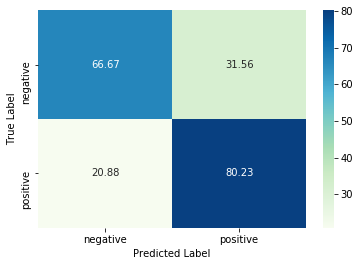

In [16]:
#!pip install matplotlib==3.1.0
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
target_names = ['negative', 'positive']
C = confusion_matrix(y_test,y_predict) 
C = C / C.astype(np.float).sum(axis=1)*100
sns.heatmap(C,annot=True, fmt=".2f",cmap="GnBu",xticklabels=target_names, yticklabels=target_names)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Deep Learning

In [17]:
#!pip install tensorflow==2.0.0-beta1
import tensorflow as tf

Design Deep Learning Model

In [27]:
tf.reset_default_graph() # Clear Model
np.random.seed(1) # Fix Randomness
tf.random.set_random_seed(1) # Fix Randomness
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(16, activation='relu', input_shape=(14,)),
  tf.keras.layers.Dense(8, activation='relu'),
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(2, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')    
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                240       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 3         
Total params: 425
Trainable params: 425
Non-trainable params: 0
_________________________________________________________________


Set up Optimizer to 'adam' with is argubly the best one now, the loss function is set to binary_crossentropy (Binary Classification).

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Train Model

In [29]:
train_acc = list()
val_acc = list()
for i in range(0,500):
  history = model.fit(X_train_norm, y_train, epochs= 1, batch_size = 200, validation_data= (X_val_norm, y_val))
  tmp_avg = np.mean(history.history['acc'])
  tmp_avg_val = np.mean(history.history['val_acc'])
  train_acc.append(tmp_avg)
  val_acc.append(tmp_avg_val)

Train on 1635 samples, validate on 409 samples
1635/1635 [==============================] - 0s 79us/sample - loss: 0.7486 - acc: 0.4930 - val_loss: 0.7035 - val_acc: 0.5110
Train on 1635 samples, validate on 409 samples
1635/1635 [==============================] - 0s 17us/sample - loss: 0.7134 - acc: 0.4985 - val_loss: 0.6860 - val_acc: 0.5599
Train on 1635 samples, validate on 409 samples
1635/1635 [==============================] - 0s 13us/sample - loss: 0.6969 - acc: 0.5443 - val_loss: 0.6776 - val_acc: 0.5868
Train on 1635 samples, validate on 409 samples
1635/1635 [==============================] - 0s 15us/sample - loss: 0.6867 - acc: 0.5688 - val_loss: 0.6739 - val_acc: 0.6210
Train on 1635 samples, validate on 409 samples
1635/1635 [==============================] - 0s 14us/sample - loss: 0.6808 - acc: 0.5914 - val_loss: 0.6709 - val_acc: 0.6479
Train on 1635 samples, validate on 409 samples
1635/1635 [==============================] - 0s 13us/sample - loss: 0.6757 - acc: 0.6257

Check Overfitting and Stopped Iteration

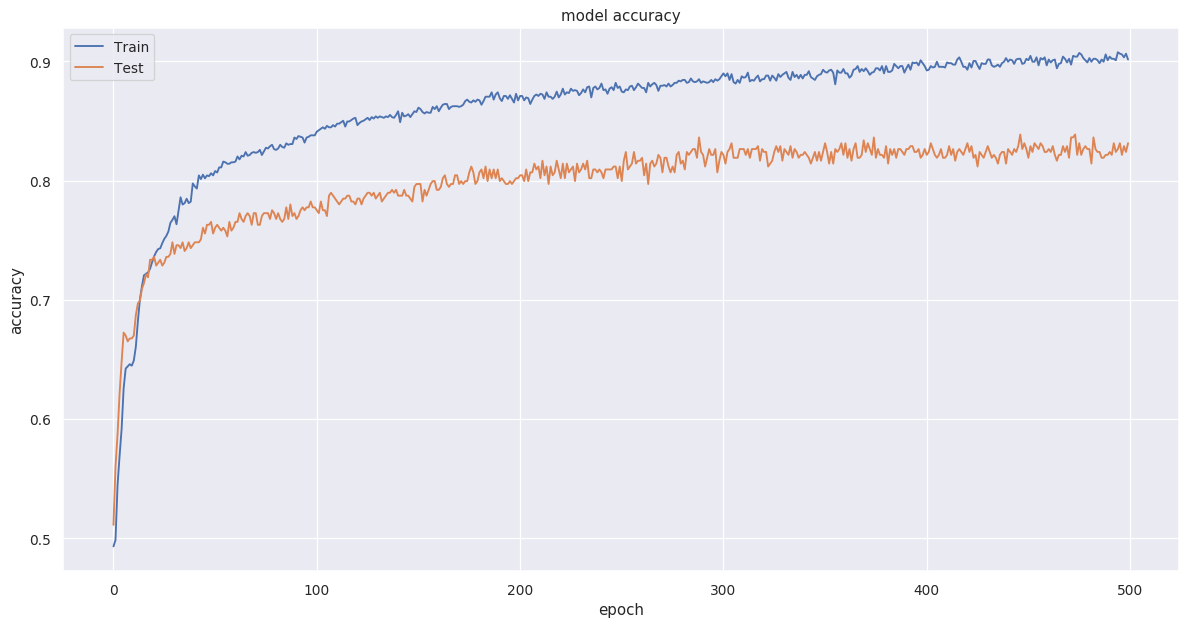

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.figure(num=None, figsize=(16, 8), dpi=90, facecolor='w', edgecolor='k')
plt.plot()
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Test Accuracy

In [31]:
y_predict = np.round(model.predict(X_test_norm))
y_predict = [i[0] for i in y_predict.tolist()]
sum(y_predict == y_test)/len(y_test)

0.849609375

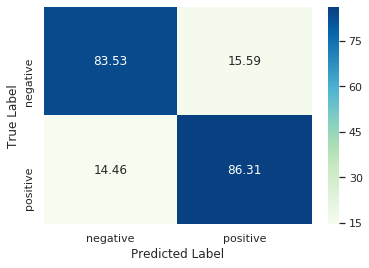

In [32]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
target_names = ['negative', 'positive']
C = confusion_matrix(y_test,y_predict) 
C = C / C.astype(np.float).sum(axis=1)*100
sns.heatmap(C, annot=True, fmt=".2f",cmap="GnBu",xticklabels=target_names, yticklabels=target_names)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Remark for multiple classification

Change label to tensor flow acceptable format

In [46]:
num_label = len(np.unique(y_train))
y_train_multi = (np.arange(num_label) == y_train[:,None]).astype(np.float32)
y_train_multi

y_val_multi = (np.arange(num_label) == y_val[:,None]).astype(np.float32)
y_val_multi

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.

Change output layers to softmax with #node = number of class

In [43]:
tf.reset_default_graph() # Clear Model
np.random.seed(1) # Fix Randomness
tf.random.set_random_seed(1) # Fix Randomness
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(16, activation='relu', input_shape=(14,)),
  tf.keras.layers.Dense(8, activation='relu'),
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(2, activation='relu'),
  tf.keras.layers.Dense(num_label, activation='softmax')    
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                240       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 6         
Total params: 428
Trainable params: 428
Non-trainable params: 0
_________________________________________________________________


Change loss to categorical_crossentropy (Multi Classification)

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Train Model

In [47]:
train_acc = list()
val_acc = list()
for i in range(0,500):
  history = model.fit(X_train_norm, y_train_multi, epochs= 1, batch_size = 200, validation_data= (X_val_norm, y_val_multi))
  tmp_avg = np.mean(history.history['acc'])
  tmp_avg_val = np.mean(history.history['val_acc'])
  train_acc.append(tmp_avg)
  val_acc.append(tmp_avg_val)

Train on 1635 samples, validate on 409 samples
1635/1635 [==============================] - 0s 91us/sample - loss: 0.7622 - acc: 0.4930 - val_loss: 0.7086 - val_acc: 0.5110
Train on 1635 samples, validate on 409 samples
1635/1635 [==============================] - 0s 13us/sample - loss: 0.7178 - acc: 0.5021 - val_loss: 0.6867 - val_acc: 0.5648
Train on 1635 samples, validate on 409 samples
1635/1635 [==============================] - 0s 15us/sample - loss: 0.6979 - acc: 0.5474 - val_loss: 0.6768 - val_acc: 0.5917
Train on 1635 samples, validate on 409 samples
1635/1635 [==============================] - 0s 18us/sample - loss: 0.6862 - acc: 0.5768 - val_loss: 0.6728 - val_acc: 0.6284
Train on 1635 samples, validate on 409 samples
1635/1635 [==============================] - 0s 15us/sample - loss: 0.6798 - acc: 0.6116 - val_loss: 0.6696 - val_acc: 0.6577
Train on 1635 samples, validate on 409 samples
1635/1635 [==============================] - 0s 18us/sample - loss: 0.6742 - acc: 0.6508

Check Overfitting and Stopped Iteration

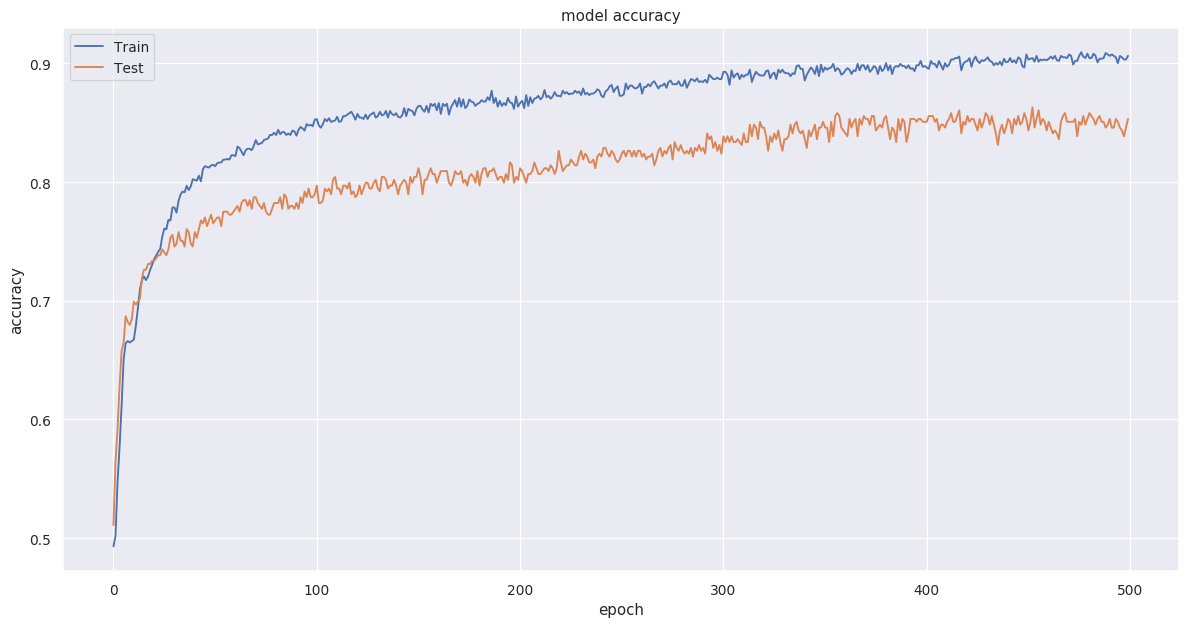

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.figure(num=None, figsize=(16, 8), dpi=90, facecolor='w', edgecolor='k')
plt.plot()
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Change test accuracy calculation

In [49]:
y_predict = model.predict(X_test_norm)
y_predict = np.argmax(y_predict, 1)
sum(y_predict == y_test)/len(y_test)

0.8359375